# iLQR Open-Loop

In [192]:
using LinearAlgebra
using TrajectoryOptimization
using PyCall
using PyPlot
include("../scripts/Params.jl");
include("../scripts/SphereConeVehicleModel.jl");

## Design parameters

In [183]:
params = Dict("r_min" => 0.20, # smallest radius of the cone [m]
              "r_max" => 1.30, # largest radius of the cone [m]
              "δ" => 40 / 360 * 2 * pi, # opening angle of the cone [rad]
              "m" => 569.7, # mass of the Phoenix entry system [kg]
              "x_g" => 0.10, # axial center-of-gravity location [m]
              "c" => 1.20, # distance between the radial axis and the cluster of thrusters[m]
              "F_max" => 36.0, # maximum force applied by the thrusters [N]
              "Jxx" => 293.15, # Phoenix entry system [kg.m^2]
              "Jyy" => 184, # Phoenix entry system [kg.m^2]
              "Jzz" => 208.02, # Phoenix entry system [kg.m^2]
              "Jxy" => 0.451, # Phoenix entry system [kg.m^2]
              "Jxz" => -4.424, # Phoenix entry system [kg.m^2] 
              "Jyz" => 0.372, # Phoenix entry system [kg.m^2]
              "g" => 3.711, # Mars gravity [m^2.s^-1]
              "h" => 10800, # Atmospheric Scale Height [m]
              "ρ_0" => 0.020, # Surface density of Mars atmosphere [kg.m^-3]
              "r_p" => 3389.5e3, # Volumetric mean radius of Mars [m]
              "ω_p" => [0, 0, 7.088e-05]) # Angular velocity of Mars [rad.s^-1]
complete_params!(params);
params["l"]


1.5492796703724732

## Initial conditions

In [184]:
# Initial conditions

# Iniitial altitude
x_0 = - 125000.0
y_0 = 0.0

# Initial speed
v_0 = 5500 * [1, 0, 0]

# Initial orientation
θ = 0.1 / 360 * 2 * pi
r = tan(θ / 4) .* [0, 0, 1]

# Initial state
X_0 = [x_0, y_0, 0, r[1], r[2], r[3], v_0[1], v_0[2], v_0[3], 0, 0, 0]

12-element Array{Float64,1}:
 -125000.0                   
       0.0                   
       0.0                   
       0.0                   
       0.0                   
       0.00043633234068908935
    5500.0                   
       0.0                   
       0.0                   
       0.0                   
       0.0                   
       0.0                   

## Analytic Model

In [185]:
# Analytic Model
function entry_vehicle_simplified_dynamics!(ẋ,x,u)
    entry_vehicle_simplified_dynamics!(ẋ, x, u, params)
end
# Number of states
n = 12
# Number of controls
m = 12

model = Model(entry_vehicle_simplified_dynamics!, n, m)

TrajectoryOptimization.AnalyticalModel(entry_vehicle_simplified_dynamics!, 12, 12, [0], Dict{Symbol,Any}(:evals=>0))

## Cost Function

In [186]:
# Cost Function

# Stage cost
Q_diag = 1e-4 * [0, 1e1, 1e1, 1e0, 1e0, 1e0, 0, 1e-2, 1e-2, 1e0, 1e0, 1e0]
Q = convert(Array{Float64,2}, Diagonal(Q_diag))

# Control cost
R_diag = 1e-4 * ones(12)
R = convert(Array{Float64,2}, Diagonal(R_diag))

# Final stage cost
Qf_diag = 1e-1 * [0, 1e1, 1e1, 1e0, 1e0, 1e0, 0, 1e-2, 1e-2, 1e0, 1e0, 1e0]
Qf = convert(Array{Float64,2}, Diagonal(Qf_diag))

# Final state objective
xf = zeros(n)
xf[1] = - 125000.0 - 3389.5e3 + 25000

cost_function = LQRCost(Q, R, Qf, xf);

## Constrained Objective

In [187]:
# Final time 
tf = 15.0
#Initial State
x0 = X_0
# Lower control bounds (m,)
u_min = zeros(m)
# Upper control bounds (m,)
F_max = params["F_max"]
u_max = F_max * ones(m)

unconstrained_objective = UnconstrainedObjective(cost_function, tf, x0, xf)
constrained_objective = ConstrainedObjective(unconstrained_objective, 
    u_min=u_min, u_max=u_max, use_xf_equality_constraint=false);

## Solver

In [188]:
# Number of time steps
N = 1500
solver = Solver(model, constrained_objective, N=N)
# Initial control trajectory
U0 = zeros(m, N-1);
# Solving the problem
X0 = rollout(solver, U0)
# results, stats = solve(solver, U0);

In [189]:
# [TrajectoryOptimization.stage_cost(cost_function,X0[:,i],U0[:,i]) for i =1:N-1]
# X0[:, 3]
size(X0)

(12, 1500)

In [190]:
function process_solution(solver, X0, params) 
    sol_x = X0' #hcat(results.X...)'
#     sol_u = hcat(results.U...)'
    N = solver.N
    dt = solver.dt
    tf = (N-1) * dt
    sol_t = range(0.0, stop=tf, length=N)
    N = size(sol_t)[1]
    v = sol_x[:, 7:9]
    r = sol_x[:, 4:6]
    
    V_inf = zeros(N, 3)
    α = zeros(N)
    altitude = zeros(N)
    velocity_norm = zeros(N)

    F_a = zeros(N, 3)
    τ_a = zeros(N, 3)
#     F_c = zeros(N, 3)
#     τ_c = zeros(N, 3)
#     F = zeros(N, 3)
#     τ = zeros(N, 3)
    F_a_norm = zeros(N)
    τ_a_norm = zeros(N)
#     F_c_norm = zeros(N)
#     τ_c_norm = zeros(N)
    F_norm = zeros(N)
    τ_norm = zeros(N)
    
    
    for i=1:N
        R = mrptodcm(r[i, :])
        V_inf[i, :] = - R' * v[i, :]
        velocity_norm[i] = norm(v[i, :])
    end
    
    α = atan.(sqrt.(V_inf[:, 2].^2 + V_inf[:, 3].^2) ./ V_inf[:, 1])
    for i=1:N
        R = mrptodcm(r[i, :])
        altitude[i] = norm(sol_x[i, 1:3]) - params["r_p"]
        ρ_inf = params["ρ_0"]

        F_hat = params["F_hat"]
        τ_hat = params["τ_hat"]
        F_a[i, :], τ_a[i, :] = illuminated_aerodynamics_online(F_hat, τ_hat, ρ_inf, V_inf[i, :])
        # Compute force norms and torque norms
        F_a_norm[i] = norm(F_a[i, :])
        τ_a_norm[i] = norm(τ_a[i, :])
        
#         if i < N
#             # Control forces and moments in body_frame
#             F_c[i, :], τ_c[i, :] = reaction_control_system(sol_u[i, :], params)
#         else
#             F_c[i, :], τ_c[i, :] = [0, 0, 0], [0, 0, 0]
#         end
#         # Forces and moments in body-frame
#         F[i, :] = F_a[i, :] + F_c[i, :]
#         τ[i, :] = τ_a[i, :] + τ_c[i, :]

        # Compute force norms and torque norms
        F_a_norm[i] = norm(F_a[i, :])
        τ_a_norm[i] = norm(τ_a[i, :])
#         F_c_norm[i] = norm(F_c[i, :])
#         τ_c_norm[i] = norm(τ_c[i, :])
#         F_norm[i] = norm(F[i, :])
#         τ_norm[i] = norm(τ[i, :])
    end
    sol_x = cat(dims=2, sol_x, α) 
    sol_x = cat(dims=2, sol_x, altitude)    
    sol_x = cat(dims=2, sol_x, velocity_norm) 
    sol_x = cat(dims=2, sol_x, V_inf)
    
    sol_x = cat(dims=2, sol_x, F_a)
    sol_x = cat(dims=2, sol_x, F_a_norm)   
    sol_x = cat(dims=2, sol_x, τ_a)
    sol_x = cat(dims=2, sol_x, τ_a_norm)   
#     sol_x = cat(dims=2, sol_x, F)
#     sol_x = cat(dims=2, sol_x, F_norm)   
#     sol_x = cat(dims=2, sol_x, τ)
#     sol_x = cat(dims=2, sol_x, τ_norm)  
    
#     sol_u = cat(dims=2, sol_u, F_c[1:N-1, :])
#     sol_u = cat(dims=2, sol_u, F_c_norm[1:N-1, :])   
#     sol_u = cat(dims=2, sol_u, τ_c[1:N-1, :])
#     sol_u = cat(dims=2, sol_u, τ_c_norm[1:N-1, :])   
    return sol_x, sol_t
end
sol_x, sol_t = process_solution(solver, X0, params);

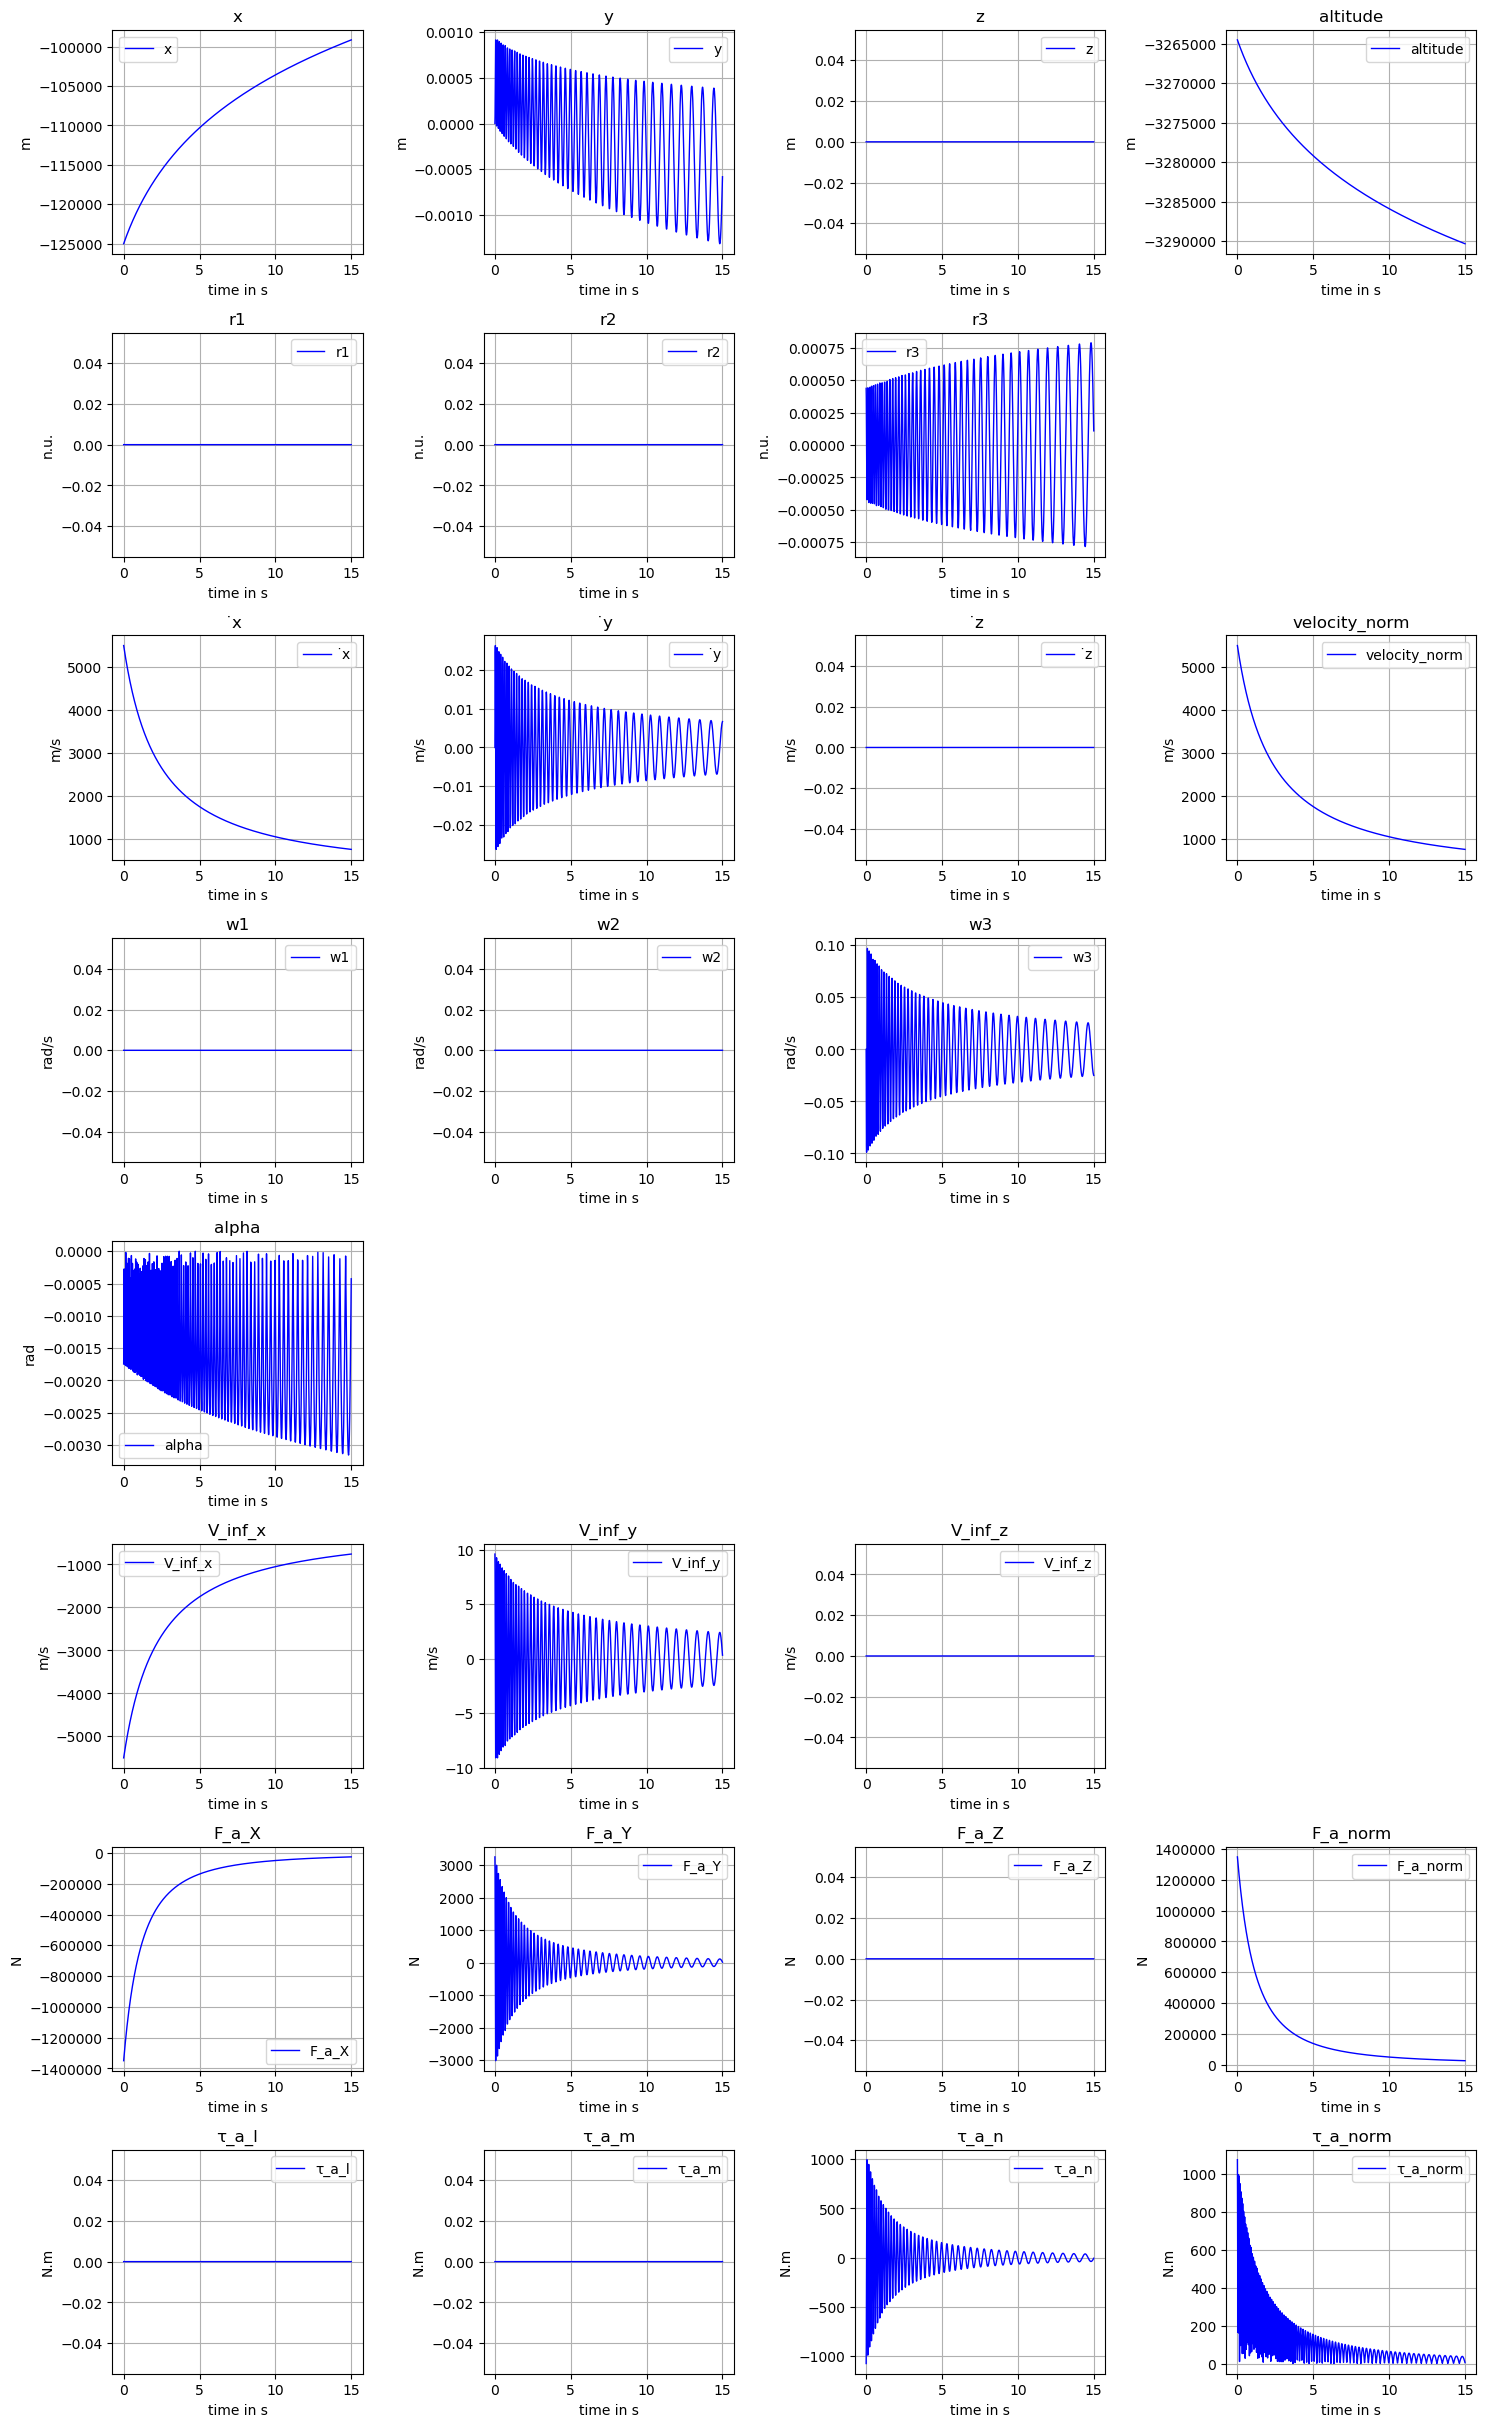

26


In [191]:
function plot_state_trajectory(sol_x, sol_t, params; display=true)
    figure(figsize=(15,30))
    labels = ["x", "y", "z", 
        "r1", "r2", "r3", 
        "̇x", "̇y", "̇z",
        "w1", "w2", "w3", 
        "alpha", 
        "altitude", 
        "velocity_norm",
        "V_inf_x", "V_inf_y", "V_inf_z",
        "F_a_X", "F_a_Y", "F_a_Z", "F_a_norm",
        "τ_a_l", "τ_a_m", "τ_a_n", "τ_a_norm"]#,
#         "F_X", "F_Y", "F_Z", "F_norm",
#         "τ_l", "τ_m", "τ_n", "τ_norm"]
    units = ["m", "m", "m", 
        "n.u.", "n.u.", "n.u.",
        "m/s", "m/s", "m/s", 
        "rad/s", "rad/s", "rad/s", 
        "rad",
        "m",
        "m/s",
        "m/s", "m/s", "m/s", 
        "N", "N", "N", "N", 
        "N.m", "N.m", "N.m", "N.m"]#, 
#         "N", "N", "N", "N", 
#         "N.m", "N.m", "N.m", "N.m"]
    indexes = [1, 2, 3,
        5, 6, 7, 
        9, 10, 11,
        13, 14, 15,
        17,
        4, 
        12, 
        21, 22, 23,
        25, 26, 27, 28,
        29, 30, 31, 32]#, 
#         33, 34, 35, 36, 
#         37, 38, 39, 40]
    y_lims = [nothing, nothing, nothing,
        nothing, nothing, nothing,
        nothing, nothing, nothing,
        nothing, nothing, nothing,
#         (-pi/2, pi/2),
        nothing,
        nothing,
        nothing,
        nothing, nothing, nothing,
        nothing, nothing, nothing, nothing,
        nothing, nothing, nothing, nothing]#,
#         nothing, nothing, nothing, nothing,
#         nothing, nothing, nothing, nothing]
    println(length(labels))
    for i=1:length(labels)
        sol_y = sol_x[:, i]
        subplot(10, 4, indexes[i])
        plot(sol_t, sol_y, color="blue", linewidth=1.0, 
            linestyle="-", label=labels[i])
        legend()
        title(labels[i])
        grid("on")
        xlabel("time in s")
        ylabel(units[i])
        ylim(y_lims[i])     
    end
    if display
        tight_layout() 
        show()
    end
    return
end

plot_state_trajectory(sol_x, sol_t, params)

In [45]:
# function plot_control_trajectory(sol_u, sol_t, params; display=true)
#     figure(figsize=(15,25))
#     labels = ["T11", "T12", "T13", 
#         "T21", "T22", "T23",
#         "T31", "T32", "T33", 
#         "T41", "T42", "T43", 
#         "F_c_x", "F_c_y", "F_c_z", "F_c_norm",
#         "τ_c_x", "τ_c_y", "τ_c_z", "τ_c_norm"]
        
#     units = ["N", "N", "N", 
#         "N", "N", "N", 
#         "N", "N", "N", 
#         "N", "N", "N", 
#         "N", "N", "N", "N",
#         "N", "N", "N", "N"]

#     indexes = [1, 2, 3,
#         5, 6, 7,
#         9, 10, 11,
#         13, 14, 15,
#         17, 18, 19, 20, 
#         21, 22, 23, 24]
    
#     y_lims = [nothing, nothing, nothing,
#         nothing, nothing, nothing,
#         nothing, nothing, nothing,
#         nothing, nothing, nothing,
#         nothing, nothing, nothing, nothing,
#         nothing, nothing, nothing, nothing,]
    
#     for i=1:length(labels)
#         sol_y = sol_u[:, i]
#         subplot(6, 4, indexes[i])
#         plot(sol_t[1:end-1], sol_y, color="blue", linewidth=1.0, 
#             linestyle="-", label=labels[i])
#         legend()
#         title(labels[i])
#         grid("on")
#         xlabel("time in s")
#         ylabel(units[i])
#         ylim(y_lims[i])     # set the ylim to bottom, top
#     end
#     if display
#         tight_layout() 
#         show()
#     end
#     return
# end

# plot_control_trajectory(sol_u, sol_t, params)

In [14]:
# plot(results.X,1:4)
# solver.obj.xf
# solver.obj.use_xf_equality_constraint 